# Python for Data 28: Genralized Linear Mixed Models (GLMM)

#### Linear Model

A Linear model has the following assumptions regarding the resuidals: 
1. Normally Distributed 
2. Independent 
3. Equal Variance 

<a id="toc"></a>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Contents</h2>

<br><a href="#ols">1. Linear Model</a>
<br><a href="#glmm">2. Generalized Linear Mixed Models (GLMM)</a> 
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#norm">a) Gaussian (Normal) Family</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#gamma">b) Gamma for proportional count response</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#binomial">c) Binomial response</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#unorderedMulti">d) Unordered Multinomial response</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#orderedMulti">e) Ordered Multinomial response</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#possion">f) Possion response</a>
<br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#negBin">g) Negative Binomial response</a>



In [1]:
# Import libraries
import os
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
from statsmodels.compat import lzip
from scipy.stats import skew, norm, kurtosis
from scipy import stats 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rcParams['figure.figsize'] = (7, 6)
colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
sns.set_context('talk')
sns.set(style="whitegrid")
sns.set_palette(palette= sns.color_palette("RdBu",20))

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
# InteractiveShell.ast_node_interactivity = 'last_expr'

In [4]:
import pandas as pd
# use the following to suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

# <a id="ols">1. Ordinary Least Square (OLS) Linear Model </a>
<img src="https://miro.medium.com/v2/resize:fit:1000/1*93cpz5redQH1zuo3H9ZwIg.png" width = 500>


## a) Generate Data

In [5]:
np.random.seed(42)
nsample = 1000

x = np.linspace(0,20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2 , np.ones(nsample)))

beta = np.array([0.5, 0.5, -0.02, 5.])
y_true = np.dot(X, beta)

# final data
random_col = np.random.normal(size=nsample)
X = np.column_stack((X, random_col)) # add irrelevant column

y = y_true + 0.5 * np.random.normal(size=nsample) # Adds noise

### b) Create OLS model

In [6]:
ols_lr = sm.OLS(endog=y, exog=X).fit()
y_hat = ols_lr.predict()
#### or use this function ####
# y_hat = ols_lr.fittedvalues
y_hat[:10]

array([4.55504459, 4.59184733, 4.60164531, 4.60972119, 4.66776179,
       4.69239861, 4.6825613 , 4.72253524, 4.77053651, 4.77577814])

### c) Evalution

In [7]:
print("Parameters: ", ols_lr.params)
print("Std Errors: ", ols_lr.bse)
print("R Squared", ols_lr.rsquared)

Parameters:  [ 0.49622914  0.54248414 -0.01976824  5.05868354 -0.01899075]
Std Errors:  [0.00605369 0.02305214 0.00053252 0.0392514  0.01612086]
R Squared 0.9282772796601143


In [8]:
ols_lr_res = ols_lr.summary()
print(ols_lr_res)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     3219.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        07:27:42   Log-Likelihood:                -719.63
No. Observations:                1000   AIC:                             1449.
Df Residuals:                     995   BIC:                             1474.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4962      0.006     81.971      0.0

### d) Explain the results

### **Table 1**

**Df Residuals:** 
The Degrees of Freedom. DF = no.of obs - no.of features - 1 ( $df = n-k-1$).

**Df Model:** 
The number of predictors (no.of features $k$).

**Covariance:** 
It is the relationship between each 2 vars.
- "nonrobust" means that the method used to calculate covariance is not robust against outliers 
- Robust methods are less sensitive to outliers or influential data points.
- Outliers can **inflate the covariance value**.This can lead to misleading interpretations of the relationship between variables.

**R-squared:** 
It measures how much of the independent variables are explained by changes in our dependent variables.
- Here R-squared value is 0.939, then it means that X can explain 93.9% of the variation in the y.
- Range between 0 to 1
- Note that adding features to the model always increase R-squared.

**Adjusted R-squared:** 
R-squared value will never go down with additional variables (even if they are poorly contributing), only equal or higher. The adjusted R-squared penalizes the R-squared formula based on the number of variable.
- A lower adjusted score may be telling you some variables are not contributing to your model.
- Range between 0 to 1

**F-statistic:**

It indicates whether your OLS model provides a better fit than the base line model (intercept-only model, constant line, all y=mean os all the ys).

- $H_0$: model with no features fits the data as well as your model.
- $H_a$: Tyour model fits the data better than the intercept-only model.

**Prob (F-Statistic):**
It is the p-value of the test statictics.
- Here p-value is 2.99e-88 (< significance level (alpha = 0.05)), then we can reject the $H_0$ and accept $H_a$.

**Log-likelihood:** 
Likelihood Ratio test (LR test) used to compare the goodness of fit of two models, focusing on the improvement in likelihood value.
- Log likelihood values can range from -inf to +inf. 
- When adding predictor variables to a model, both R-squared and likelihood tend to improve. 
- It evaluates whether the improvement in likelihood due to adding more predictor variables to a model is significant or not.

**AIC and BIC:** 
https://medium.com/swlh/what-do-we-see-with-aic-bic-57b3e12685d

---
### **Table 2**

**coefficients:**
The coefficients multiplied by the features to predict the target value.
**std error:** 
An estimate of the standard deviation of the **coefficient**, the amount it varies across cases. 
- The smaller the standard error, the more precise the estimate.
- E.g.,if std error of the `x3` coefficient is smaller than that of `x1` coefficient.Therefore, the model is able to estimate the coefficient for `x3` with greater precision.

**t:**
A measurement of the precision of coefficient.
- Dividing the coefficient by its standard error calculates a t-value.
- A low std error compared to a high coefficient produces a high t statistic.

**p<|t|:**
If p-value is less than the alpha level (~0.05), you conclude that the coefficient is **significantly different from zero**.
- A high t statistic produces low p-value -> reject $H_0$ ->  coefficient is significantly different from zero.
- If p-value < level of significance (0.05); then null hypothesis is rejected.
- If p-value > level of significance (0.05); then we fail to reject the null hypothesis.

**[0.025 and 0.975]:**
Both measurements of values of our coefficients within 95% confidance interval.


---
### **Table 3**


**Omnibus:**
Describes the normalcy of the distribution of our residuals using skew and kurtosis as measurements. 
- A 0 would indicate perfect normalcy.

**Prob(Omnibus):**
The probability the **residuals** are normally distributed. 
- A 1 would indicate perfectly normal distribution.

**Skew:** 
A measurement of symmetry in our data.
- 0 being perfect symmetry.

**Kurtosis:** 
The peakiness of our data, or its concentration around 0 in a normal curve. 
- Higher kurtosis implies fewer outliers.

**Durbin-Watson:** 
A measurement for **autocorrelation of residuals**. It must lie between **0 and 4**. Using usually in time series.

- DW = 2, or close to it, implies no autocorrelation
- 0 < DW < 2 implies positive autocorrelation
- 2 < DW < 4 indicates negative autocorrelation

**Jarque-Bera (JB) and Prob(JB):**
They are alternate methods of measuring the **same value as Omnibus and Prob(Omnibus)** using skewness and kurtosis. We use these values to confirm each other. 
- $H_0$: Residuals are normally distributed.
- $H_a$: Residuals are not normally distributed.
- Here the Jarque-Bera statistic for the test is 7.866 and the corresponding p-value is 0.0196, we will accept $H_a$. 

**Cond. No.:**
A diagnostic for multicollinearity. Multicollinearity is strongly implied by a high condition number.
- Calculated by computing the eigenvalues of the correlation matrix and taking the square root of the ratio of the largest eigenvalue to the smallest eigenvalue.
- Cond. No.< 30: No multicollinearity.
- 30 < Cond. No.< 100: moderate multicollinearity, which may affect the precision of the estimates but is generally acceptable.
- Cond. No. > 100: severe multicollinearity, which can lead to unreliable estimates of the regression coefficients.

### e) Ploting Regression line and confidance interval 

#### wls_prediction_std
calculate standard deviation and confidence interval for prediction

- predstd : standard error of prediction
- interval_l, interval_u : lower und upper confidence bounds

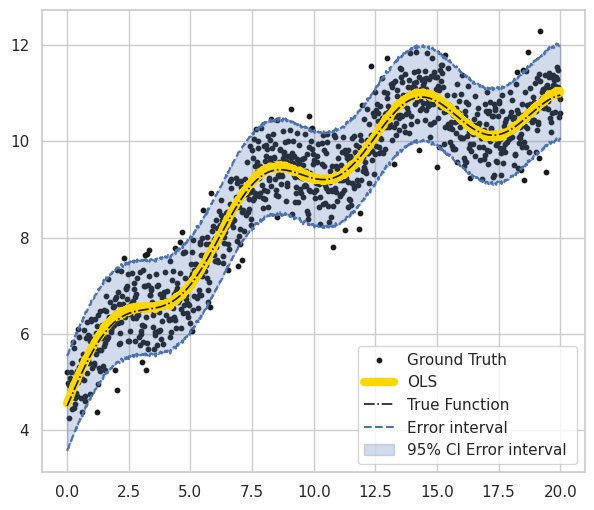

In [9]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

def plot_OLS_line(model):

    predstd, interval_l, interval_u = wls_prediction_std(model)
    plt.scatter(x, y, s=10,color='k', label='Ground Truth')
    plt.plot(x, model.fittedvalues, label='OLS', color='gold',linewidth=6)
    plt.plot(x, y_true, 'k-.',label='True Function',linewidth=1.2)
    plt.plot(x, interval_l, 'b--',label='Error interval')
    plt.plot(x, interval_u, 'b--')
    plt.fill_between(x, interval_l, interval_u, color='b', alpha=0.25, label='95% CI Error interval ')
    plt.legend(loc='best')
    plt.show()

plot_OLS_line(ols_lr)

### e) General model (linear regression) assumption check

In [10]:
df = pd.DataFrame(X, columns=['x1','x2', 'x3', 'x4', 'x5'])
df['y'] = y

#### Check Linearity between X and y

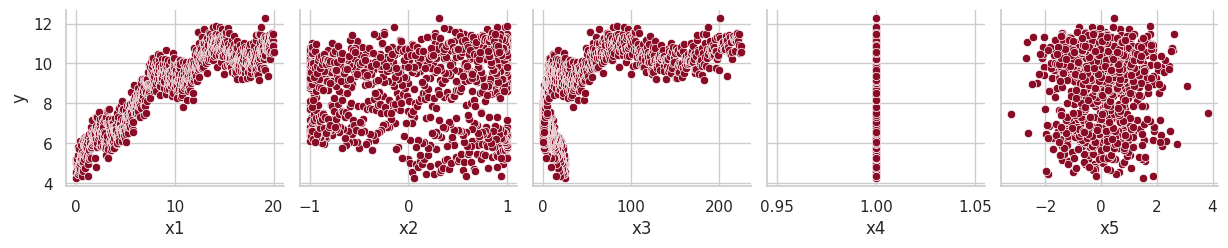

In [11]:
sns.pairplot(df, y_vars=['y'], x_vars = ['x1','x2', 'x3', 'x4', 'x5'])

> **Relations between y and Xs are not linear**

#### Check Multicolinearity 

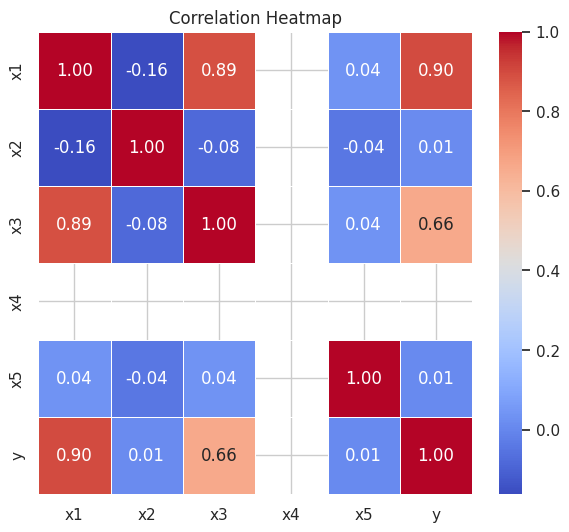

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Calculate VIF for each variable
variables = df.values
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif_data

,Variable,VIF
0,x1,38.238
1,x2,1.632
2,x3,11.534
3,x4,109.838
4,x5,1.004
5,y,13.943


> **We should remove `x4` and `x3`, i will keep them to try more experiment with the GLM regarding the significance test**

#### Check Target distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


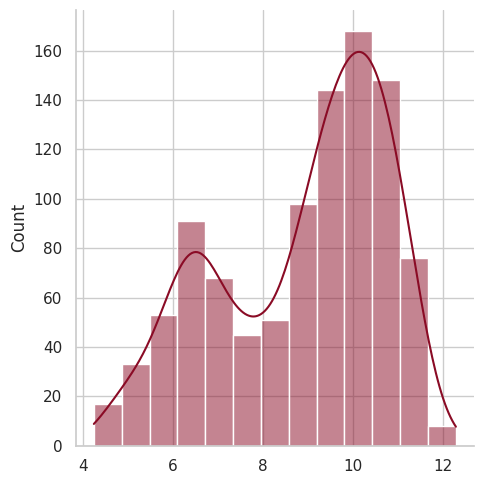

In [14]:
sns.displot(y, kde = True)

> **$y$ not normally distributed**

#### Check Resdiual zero Mean

In [15]:
np.mean(y-y_hat)

6.729727886067849e-15

#### Check Resdiual Normality

In [16]:
from scipy.stats import shapiro

# Perform statistic test
statistic, p_value = shapiro(y-y_hat)

print("Shapiro-Wilk Statistic:", statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis, data does not follow a Gaussian distribution.")
else:
    print("Fail to reject null hypothesis, data follows a Gaussian distribution.")

Shapiro-Wilk Statistic: 0.9985384345054626
P-value: 0.5799034237861633
Fail to reject null hypothesis, data follows a Gaussian distribution.


#### Check Heteroscedasticity

Text(0, 0.5, 'Residuals')

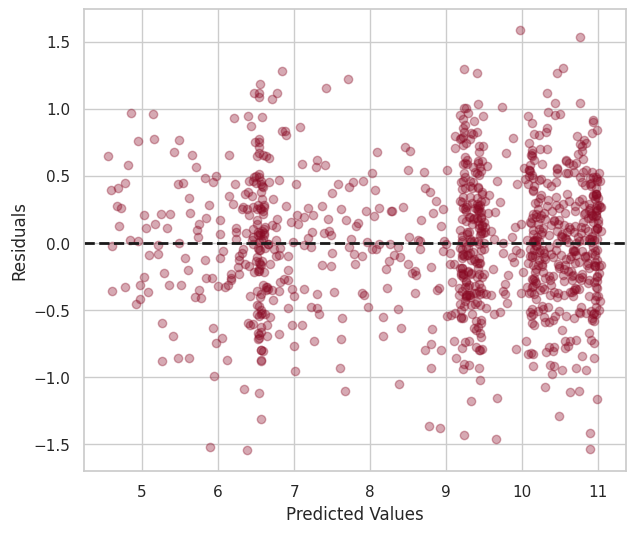

In [17]:
import numpy as np
import matplotlib.pyplot as plt


plt.scatter(y_hat, y-y_hat, alpha=0.35)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Calculate the Breusch-Pagan test statistics and p-value
bp_test_statistic, bp_p_value, _, _ = het_breuschpagan( ols_lr.resid, ols_lr.model.exog)

# Print results
print("Breusch-Pagan Test Statistic:", bp_test_statistic)
print("Breusch-Pagan P-value:", bp_p_value)

# Interpret results
alpha = 0.05
if bp_p_value < alpha:
    print("Reject null hypothesis, heteroscedasticity is present.")
else:
    print("Fail to reject null hypothesis, no evidence of heteroscedasticity.")


Breusch-Pagan Test Statistic: 0.6923189250256367
Breusch-Pagan P-value: 0.9522727654483497
Fail to reject null hypothesis, no evidence of heteroscedasticity.


# <a id="glmm">2. Genralized Linear Mixed Models (GLMM) </a>

The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a **link function**. The three components in GLM:

1. linear predictor
2. link function
3. probability distribution


1. **stochastic part**, which is a probability distribution from the exponential family (this is sometimes called the “random part”)
\begin{equation}
y_i \sim \mathrm{Prob}(\mu_i)
\end{equation}

2. **systematic part**, which is a linear predictor (I like to think about this as the deterministic part)
\begin{equation}
\eta=\mathbf{X}\boldsymbol{\beta}
\end{equation}

3. **link function** connecting the two parts.
\begin{equation}
\eta_i = g(\mu_i)
\end{equation}

    - **μ**, is the conditional mean of the response $\mathrm{E}(Y|X)$ on the **response scale**. 
    - **η**, is the conditional mean of the response on the **link scale**.

<a id="toc"></a>

<br><a href="#norm">a) Gaussian (Normal) Family</a>
<br><a href="#gamma">b) Gamma for proportional count response</a>
<br><a href="#binomial">c) Binomial response </a> 
<br><a href="#unorderedMulti">d) Unordered Multinomial response</a>
<br><a href="#orderedMulti">e) Ordered Multinomial response</a>
<br><a href="#possion">f) Possion response</a>
<br><a href="#negBin">g) Negative Binomial response</a>



| **Family** | **Link Function** | **Data Type** | **Description** |
|---|---|---|---|
Gaussian (Normal) | identity ($b_0 + b_1x$) | Continuous data | Models continuous, normally distributed data (e.g., weight).
Gamma | lnverse ($\frac{1}{b_0 + b_1x}$)| Continuous, positive data | Models continuous, positive skewed data (e.g., income levels).
Binomial | logit ($\frac{e^{b_0 + b_1x}}{1 + e^{b_0 + b_1x}}$)| Binary (0/1)| Models the probability of success for binary outcomes (e.g., success/failure).
Multinomial | logit | Multiple categories (unordered) | Probability of belonging to one of several unordered categories (e.g., department).
Ordered Multinomial | ordered logit | Ordered categories | Probability of belonging to one of several ordered categories (e.g., customer satisfaction rating on a scale).
Poisson|Log ($e^{b_0 + b_1x}$)| Count data | Number of events occurring in a fixed interval with mean = std (e.g., no. of customer arrivals).
Negative Binomial|log | Count data with overdispersion (high std)| Similar to Poisson but allows for more variability in data.


## <a id="norm">a) Gaussian (Normal) Family</a> 

\begin{align}
y_i &= \beta_0 + \beta_1 x_i + \varepsilon_i \\
\varepsilon &\sim N(0, \sigma) \\
y_i &\sim N(\mu_i, \sigma)\\
\end{align}
- A response is a random draw from a normal distribution with mean $\mu_i$ (not zero!) and variance $σ_2$
\begin{align}
\mathrm{E}(Y|X) &= \mu\\
\mu_i &= \beta_0 + \beta_1 x_i
\end{align}

We can think of a response as the sum of some systematic part and “random errror”, which is a random draw from a normal distribution with mean 0 and variance $σ_2$.


In [19]:
from scipy.stats import shapiro

# Perform statistic test
statistic, p_value = shapiro(y)

print("Shapiro-Wilk Statistic:", statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis, data does not follow a Gaussian distribution.")
else:
    print("Fail to reject null hypothesis, data follows a Gaussian distribution.")

Shapiro-Wilk Statistic: 0.9308297634124756
P-value: 4.380829707334313e-21
Reject null hypothesis, data does not follow a Gaussian distribution.


In [20]:
glm_lr = sm.GLM(endog=y, exog=X, family=sm.families.Gaussian()).fit()
y_hat = glm_lr.predict()
glm_lr_res = glm_lr.summary()
print(glm_lr_res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.24818
Method:                          IRLS   Log-Likelihood:                -719.63
Date:                Fri, 10 May 2024   Deviance:                       246.94
Time:                        07:27:48   Pearson chi2:                     247.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4962      0.006     81.971      0.0

> **The same results of `ols_lr`, as we used Gassian which use the identity linked function.**

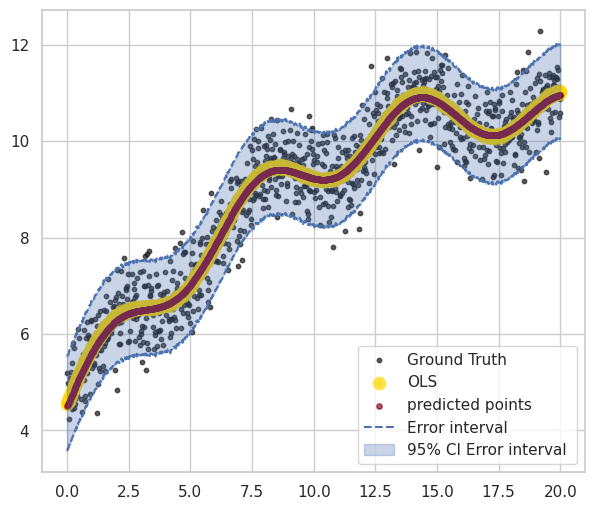

In [21]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

def plot_GLM_line(model, X, y, i=0, y_true=np.array(None), interval=True, task=None):
        
    x = pd.DataFrame(X).iloc[:,i].values
    if task=='binomial':
        y_hat = (glm_binom2.fittedvalues>0.5).astype(int)
    else:
        y_hat = model.fittedvalues
    pred_std = np.sqrt(model.scale)       # scale is the residual variance.
    interval_l = y_hat - 1.96 * pred_std  # 95% confidence interval
    interval_u = y_hat + 1.96 * pred_std

    plt.scatter(x, y, s=10, color='k', label='Ground Truth', alpha=0.7)
    plt.scatter(x, y_hat, s=15, label='OLS', color='gold',linewidth=6, alpha=0.7)
    if np.array(y_true).all()is not None:
        plt.scatter(x, y_true, s=15, label='predicted points', alpha=0.7)
#         plt.plot(x, y_true, 'k-.',label='True Function',linewidth=1.2)
    if interval:
        plt.plot(x, interval_l, 'b--',label='Error interval')
        plt.plot(x, interval_u, 'b--')
        plt.fill_between(x, interval_l, interval_u, color='b', alpha=0.3, label='95% CI Error interval ')
    plt.legend(loc='best')
    plt.show()

plot_GLM_line(glm_lr, X=X, y=y, y_true=y_true)

## <a id="gamma">b) Gamma for proportional count response </a> 

The Gamma family is commonly used for modeling continuous, positive skewed data such as reaction times, income levels, or durations. Here's how the Gamma family is typically described:
\begin{align}
y_i &\sim \text{Gamma}(\mu_i, \phi) \
\end{align}

- The response variable $𝑦_𝑖$ follows a Gamma distribution with mean $𝜇_𝑖$ and shape parameter $𝜙$.
- The mean $𝜇_𝑖$ of the Gamma distribution is modeled as a linear combination of features, similar to other GLMs:
\begin{align}
\mu_i &= g^{-1}(\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots) \
\end{align}

- $g(⋅)$ is the link function, which maps the linear predictor to the mean parameter of the Gamma distribution. 
- Commonly used link functions for the Gamma family include the identity and log functions.
- The linear predictor $\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots$ represents the systematic part of the model, capturing the relationship between the predictors and the mean of the Gamma-distributed response.
- The shape parameter $𝜙$ controls the shape of the Gamma distribution. It is often assumed to be constant across observations in a given dataset.

**$y$ distribution has to be the same as the following**

<img src="https://images.deepai.org/glossary-terms/bbd56b090f76440b90efd039431b9d88/gamma.png" alt="dependent varaible distribution">

### Check if **$y$** has Gamma distribution

In [22]:
from scipy.stats import gamma, kstest

# Perform Kolmogorov-Smirnov (KS) test
ks_statistic, p_value = kstest(y, 'gamma',args=(2, 0, 1))
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis, data does not follow a gamma distribution.")
else:
    print("Fail to reject null hypothesis, data follows a gamma distribution.")

KS Statistic: 0.9406793447936528
P-value: 0.0
Reject null hypothesis, data does not follow a gamma distribution.


In [23]:
glm_gamma = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.Log())).fit() # 
glm_gamma_res = glm_gamma.summary()
print(glm_gamma_res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                       0.0038119
Method:                          IRLS   Log-Likelihood:                -795.73
Date:                Fri, 10 May 2024   Deviance:                       3.8284
Time:                        07:27:49   Pearson chi2:                     3.79
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0650      0.001     86.661      0.0

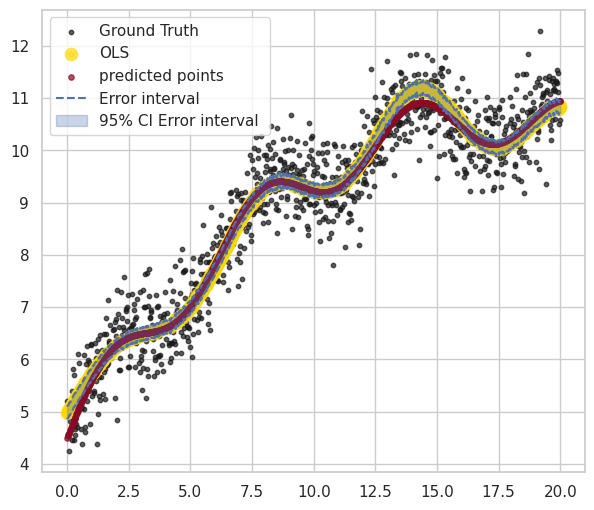

In [24]:
plot_GLM_line(glm_gamma, y=y, X=X, y_true=y_true)

## <a id="binomial">c) Binomial response </a> 

In [25]:
print(sm.datasets.star98.NOTE)

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

In [26]:
star98 = sm.datasets.star98.load_pandas().data
star98

,NABOVE,NBELOW,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,PTRATIO,PCTAF,PCTCHRT,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF
0,452.000,355.000,34.397,23.299,14.235,11.411,15.918,14.706,59.157,4.445,21.710,57.033,0.000,22.222,234.103,941.688,869.995,96.507,253.522,1238.196,13848.898,5504.035
1,144.000,40.000,17.365,29.328,8.235,9.315,13.636,16.083,59.504,5.268,20.443,64.623,0.000,0.000,219.317,811.418,957.017,107.684,340.406,1321.066,13050.223,6958.847
2,337.000,234.000,32.643,9.226,42.406,13.544,28.834,14.596,60.570,5.483,18.954,53.942,0.000,0.000,420.854,1746.495,884.054,103.924,295.759,1022.425,25491.123,5605.878
3,395.000,178.000,11.910,13.883,3.797,11.443,11.111,14.389,58.334,4.165,21.635,49.061,0.000,7.143,159.882,648.157,839.392,90.113,204.344,1061.455,9326.580,4421.057
4,8.000,57.000,36.889,12.188,76.875,7.604,43.590,13.906,63.154,4.325,18.780,52.381,0.000,0.000,606.145,2752.851,878.194,81.221,226.542,983.706,38280.262,4254.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,96.000,246.000,62.240,13.821,3.956,32.129,15.884,13.271,52.881,4.324,20.987,8.000,0.000,18.182,210.801,839.992,701.782,90.752,34.593,167.897,11147.447,726.015
299,37.000,117.000,46.162,1.151,0.800,45.623,13.333,11.807,48.426,3.945,19.858,53.774,0.000,0.000,157.428,645.682,571.774,78.342,212.140,1067.852,7623.656,4212.749
300,208.000,387.000,43.414,3.649,1.541,46.320,21.378,14.405,53.796,3.845,22.709,29.892,0.000,6.667,307.938,1150.037,774.917,87.326,114.951,678.823,16565.909,2610.402
301,199.000,510.000,70.621,20.462,2.989,17.423,11.033,16.564,61.706,3.971,24.886,15.143,0.000,13.636,182.750,680.790,1022.105,98.824,60.132,376.852,11276.740,1496.475


In [27]:
data = star98[[
        "NABOVE","NBELOW","LOWINC","PERASIAN","PERBLACK",
        "PERHISP","PCTCHRT","PCTYRRND","PERMINTE","AVYRSEXP",
        "AVSALK","PERSPENK","PTRATIO","PCTAF",]].copy()

endog = data["NABOVE"] / (data["NABOVE"] + data.pop("NBELOW"))
del data["NABOVE"]
data["SUCCESS"] = endog

In [28]:
import statsmodels.formula.api as smf

formula = "SUCCESS ~ LOWINC + PERASIAN + PERBLACK + PERHISP + PCTCHRT + \
           PCTYRRND + PERMINTE*AVYRSEXP*AVSALK + PERSPENK*PTRATIO*PCTAF"

glm_binom = smf.glm(formula, data=data, family=sm.families.Binomial())
glm_binom = glm_binom.fit()
print(glm_binom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                SUCCESS   No. Observations:                  303
Model:                            GLM   Df Residuals:                      282
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -127.33
Date:                Fri, 10 May 2024   Deviance:                       8.5477
Time:                        07:27:50   Pearson chi2:                     8.48
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1115
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [29]:
def double_it(x):
    return 2 * x


formula = "SUCCESS ~ double_it(LOWINC) + PERASIAN + PERBLACK + PERHISP + PCTCHRT + \
           PCTYRRND + PERMINTE*AVYRSEXP*AVSALK + PERSPENK*PTRATIO*PCTAF"
glm_binom2 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(glm_binom2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                SUCCESS   No. Observations:                  303
Model:                            GLM   Df Residuals:                      282
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -127.33
Date:                Fri, 10 May 2024   Deviance:                       8.5477
Time:                        07:27:50   Pearson chi2:                     8.48
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1115
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Generate Data 

In [30]:
np.random.seed(42)
nsamples = 200
nfeatures = 3

# Generate random features
X = np.random.randn(nsamples, nfeatures)

# Generate random coefficients for each feature
true_coeffs = np.random.randn(nfeatures)
y_true = (X.dot(true_coeffs)>0.5).astype(int)

# Generate target variable
num_flips = int(0.1 * len(y_true))

# Randomly select indices to flip
noise = np.random.choice(len(y_true), num_flips, replace=False)
y = y_true.copy()
y[noise] = 1 - y_true[noise]

# Print shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y_true:", y_true.shape)
print("Shape of y:", y.shape)

Shape of X: (200, 3)
Shape of y_true: (200,)
Shape of y: (200,)


In [31]:
glm_binom2 = sm.GLM(endog=y, exog=sm.add_constant(X), family=sm.families.Binomial()).fit()
print(glm_binom2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.375
Date:                Fri, 10 May 2024   Deviance:                       176.75
Time:                        07:27:50   Pearson chi2:                     409.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3889
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6906      0.204     -3.389      0.0

## <a id="unorderedMulti">d) Unordered Multinomial response </a> 

## <a id="unorderedMulti">e) Ordered Multinomial response </a> 

## <a id="possion"> f) Possion response</a>

## <a id="negBin">g) Negative Binomial response</a>
